In [73]:
from flask import Flask, redirect, render_template, request, url_for
import requests
import json
#from api_key_get import key_get
#import xml.etree.ElementTree as ET
#import xmltodict
#from collections import OrderedDict
from flask_sqlalchemy import SQLAlchemy
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import sklearn.ensemble as ske
import sklearn.metrics as skm
from sqlalchemy.sql.functions import coalesce
import numpy as np
import math

In [74]:
app = Flask(__name__)
app.debug = True

SQLALCHEMY_DATABASE_URI = "mysql+mysqlconnector://{username}:{password}@{hostname}/{databasename}".format(
    username="flaskuser",
    password="dersAGef3rover",

    hostname="127.0.0.1",
    databasename="organic_integrity",
)
app.config["SQLALCHEMY_DATABASE_URI"] = SQLALCHEMY_DATABASE_URI
app.config["SQLALCHEMY_POOL_RECYCLE"] = 299
app.config["SQLALCHEMY_TRACK_MODIFICATIONS"] = False

db = SQLAlchemy(app)
#app.secret_key = ""
#login_manager = LoginManager()
#login_manager.init_app(app)
#migrate = Migrate(app, db)

In [75]:
# Models
class OrganicOperation(db.Model):
    __tablename__ = "organic_operation"
    op_certifierName = db.Column(db.String(256))
    op_nopOpID = db.Column(db.String(256), primary_key=True)
    op_name = db.Column(db.String(256))
    op_otherNames = db.Column(db.String(256))
    op_clientID = db.Column(db.String(256))
    op_contFirstName = db.Column(db.String(256))
    op_contLastName = db.Column(db.String(256))
    op_status = db.Column(db.String(256))
    op_statusEffectiveDate = db.Column(db.DateTime)
    op_nopAnniversaryDate = db.Column(db.DateTime)
    op_lastUpdatedDate = db.Column(db.DateTime)
    opSC_CR = db.Column(db.String(256))
    opSC_CR_ED = db.Column(db.DateTime)
    opSC_LS = db.Column(db.String(256))
    opSC_LS_ED = db.Column(db.DateTime)
    opSC_WC = db.Column(db.String(256))
    opSC_WC_ED = db.Column(db.DateTime)
    opSC_HANDLING = db.Column(db.String(256))
    opSC_HANDLING_ED = db.Column(db.DateTime)
    opPA_line1 = db.Column(db.String(256))
    opPA_line2 = db.Column(db.String(256))
    opPA_city = db.Column(db.String(256))
    opPA_state = db.Column(db.String(256))
    opPA_country = db.Column(db.String(256))
    opPA_zip = db.Column(db.String(256))
    opPA_countyCode = db.Column(db.String(256))
    opPA_county = db.Column(db.String(256))
    opMA_line1 = db.Column(db.String(256))
    opMA_line2 = db.Column(db.String(256))
    opMA_city = db.Column(db.String(256))
    opMA_state = db.Column(db.String(256))
    opMA_country = db.Column(db.String(256))
    opMA_zip = db.Column(db.String(256))
    opMA_countyCode = db.Column(db.String(256))
    opMA_county = db.Column(db.String(256))
    op_phone = db.Column(db.String(256))
    op_email = db.Column(db.String(256))
    op_url = db.Column(db.String(256))
    op_opExtraInfo = db.Column(db.String(256))
    opEx_broker = db.Column(db.String(256))
    opEx_csa = db.Column(db.String(256))
    opEx_copacker = db.Column(db.String(256))
    opEx_dairy = db.Column(db.String(256))
    opEx_distributor = db.Column(db.String(256))
    opEx_marketerTrader = db.Column(db.String(256))
    opEx_restaurant = db.Column(db.String(256))
    opEx_retailer = db.Column(db.String(256))
    opEx_poultry = db.Column(db.String(256))
    opEx_privateLabeler = db.Column(db.String(256))
    opEx_slaughterHouse = db.Column(db.String(256))
    opEx_storage = db.Column(db.String(256))
    opEx_growerGroup = db.Column(db.String(256))
    opCert_url = db.Column(db.String(256))


class OrganicItem(db.Model):
    __tablename__ = "organic_item"
    ci_artID = db.Column(db.Integer, primary_key=True) # Artificial primary key added in.
    ci_nopOpID = db.Column(db.String(256), db.ForeignKey(OrganicOperation.op_nopOpID))
    ci_certNumber = db.Column(db.String(256))
    ci_nopScope = db.Column(db.String(256))
    ci_nopCategory = db.Column(db.String(256))
    ci_nopCatID = db.Column(db.String(256))
    ci_nopCatName = db.Column(db.String(256))
    ci_nopItemID = db.Column(db.String(256))
    ci_itemList = db.Column(db.String(256))
    ci_varieties = db.Column(db.String(256))
    ci_status = db.Column(db.String(256))
    ci_statusEffectiveDate = db.Column(db.String(256))
    ci_organic100 = db.Column(db.String(256))
    ci_organic = db.Column(db.String(256))
    ci_madeWithOrganic = db.Column(db.String(256))
    fk_operation_ID = db.relationship("OrganicOperation", foreign_keys=ci_nopOpID)

In [76]:
us_date = db.session.query(
    OrganicOperation.op_statusEffectiveDate,
    OrganicOperation.op_status,
    db.func.count(OrganicOperation.op_nopOpID).label("op_count")
    ).select_from(OrganicOperation).group_by(
    OrganicOperation.op_statusEffectiveDate,
    OrganicOperation.op_status
    ).filter(OrganicOperation.opPA_country.like("%United States%")).all()


In [78]:
trend_df = pd.DataFrame(us_date)
trend_df['year'] = pd.DatetimeIndex(trend_df['op_statusEffectiveDate']).year
#trend_df['op_statusEffectiveDate'] = trend_df['op_statusEffectiveDate'].apply(lambda x: x.replace(day=1))
trend_df = trend_df.loc[trend_df['year'] > 2018]
trend_df = trend_df.loc[trend_df["op_status"] != "Applied; APEDA Certified"]

trend_df = trend_df.groupby(['op_status','op_statusEffectiveDate'], as_index=False)['op_count'].sum()

trend_df = trend_df.pivot_table(
    index="op_statusEffectiveDate", 
    columns="op_status", 
    values="op_count",
    aggfunc="sum", fill_value=0,
    margins=False)

trend_df["Trend"] = trend_df["Certified"] - (trend_df["Revoked"] + trend_df["Surrendered"] + trend_df["Suspended"])

In [79]:
trend_df

op_status,Certified,Revoked,Surrendered,Suspended,Trend
op_statusEffectiveDate,,,,,
2019-01-01,10,0,0,0,10
2019-01-02,2,0,0,6,-4
2019-01-03,2,0,0,0,2
2019-01-04,2,0,0,0,2
2019-01-07,4,0,0,0,4
...,...,...,...,...,...
2022-04-11,5,0,4,1,0
2022-04-12,2,0,6,0,-4
2022-04-13,3,0,1,0,2


(array([17897., 18017., 18140., 18262., 18383., 18506., 18628., 18748.,
        18871., 18993., 19113.]),
 [Text(17897.0, 0, '2019-01'),
  Text(18017.0, 0, '2019-05'),
  Text(18140.0, 0, '2019-09'),
  Text(18262.0, 0, '2020-01'),
  Text(18383.0, 0, '2020-05'),
  Text(18506.0, 0, '2020-09'),
  Text(18628.0, 0, '2021-01'),
  Text(18748.0, 0, '2021-05'),
  Text(18871.0, 0, '2021-09'),
  Text(18993.0, 0, '2022-01'),
  Text(19113.0, 0, '2022-05')])

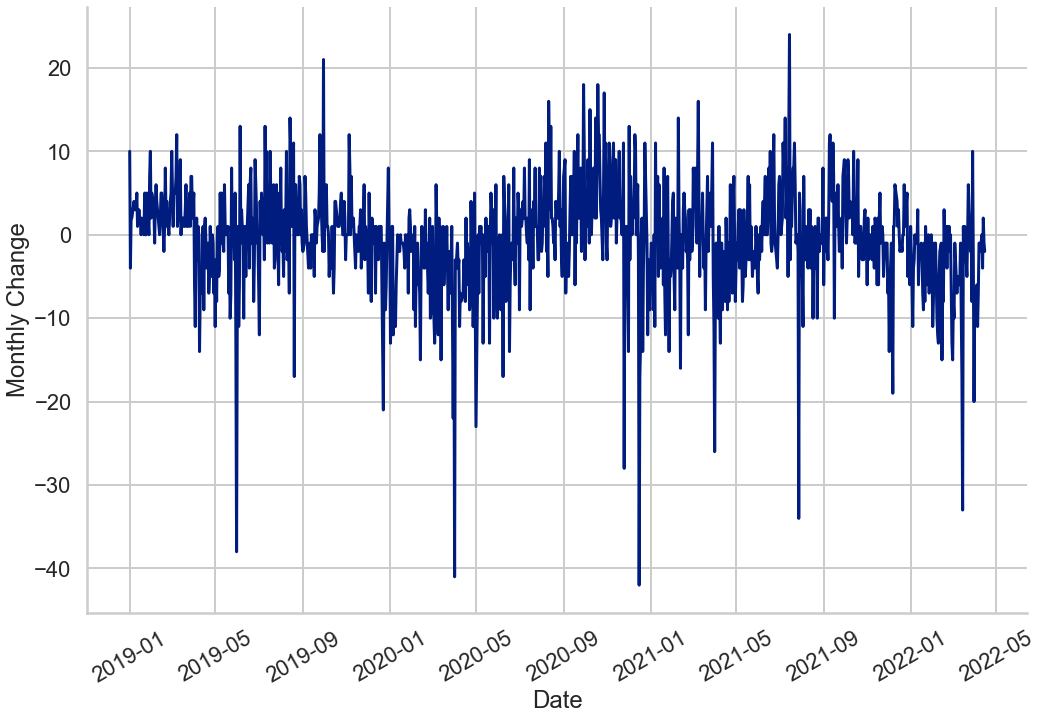

In [80]:
sns.set_style('whitegrid')
sns.set_palette('dark')
sns.set_context("poster")
sns.relplot(data=trend_df, x='op_statusEffectiveDate', y='Trend', kind='line',height=10, aspect=1.5)

#plt.title('Certification Changes Over Time')
plt.xlabel('Date')
plt.ylabel('Monthly Change')
plt.xticks(rotation=30)

In [81]:
# Try to get a change in overal count
sum(trend_df["Trend"])

-401

In [82]:
us_df = pd.DataFrame(us_date)

In [83]:
us_cert_current = sum(us_df.loc[us_df["op_status"]=="Certified","op_count"])

In [84]:
us_cert_current

23604

In [85]:
def trend_change(trend):
    global us_cert_current
    us_cert_current = us_cert_current - trend
    return us_cert_current

In [86]:
trend_df["total_count"] = trend_df["Trend"].apply(trend_change)

In [ ]:

sns.set_style('whitegrid')
sns.set_palette('flare')
sns.set_context("poster")
sns.relplot(data=trend_df, x='op_statusEffectiveDate', y='total_count', kind='line',height=10, aspect=1.5)

#plt.title('Certification Changes Over Time')
plt.xlabel('Date')
plt.ylabel('Monthly Change')
plt.xticks(rotation=30)

In [87]:
trend

op_statusEffectiveDate
2019-01-01     67
2019-02-01     65
2019-03-01    104
2019-04-01    -89
2019-05-01    -82
2019-06-01      2
2019-07-01     48
2019-08-01     53
2019-09-01     41
2019-10-01     23
2019-11-01     30
2019-12-01    -50
2020-01-01    -84
2020-02-01   -100
2020-03-01   -127
2020-04-01   -151
2020-05-01    -72
2020-06-01    -46
2020-07-01     48
2020-08-01     78
2020-09-01     92
2020-10-01    162
2020-11-01     74
2020-12-01    -73
2021-01-01    -50
2021-02-01    -21
2021-03-01     53
2021-04-01   -120
2021-05-01    -40
2021-06-01     44
2021-07-01    100
2021-08-01    -42
2021-09-01     62
2021-10-01     51
2021-11-01    -29
2021-12-01    -45
2022-01-01    -87
2022-02-01   -116
2022-03-01   -132
Name: Trend, dtype: int64

In [88]:
# Transform the trend data into a format for supervised learning.
trend = trend_df.Trend

# Remove the current month from the data, as the full count is not in place.
c_y = str(datetime.datetime.now().year)
c_m = str(datetime.datetime.now().month)
c_start_m = c_y + "-" + c_m + "-01"
current = datetime.datetime.strptime(c_start_m, "%Y-%m-%d")

trend = trend.loc[trend.index < current]

# Get the trends column and the shifted data column into a new dataframe. Extract values.
trends = pd.DataFrame(trend)
trends["Shift_Back_1"] = trends["Trend"]

trends.Shift_Back_1 = trends.Shift_Back_1.shift(1)

trends["Shift_Back_2"] = trends.Shift_Back_1.shift(1)

trends["Shift_Back_3"] = trends.Shift_Back_1.shift(2)

In [89]:
# Reorganize the columns.
trends = trends[["Shift_Back_3", "Shift_Back_2", "Shift_Back_1", "Trend"]]

In [90]:


trends = trends.dropna()

trend_vals = trends.values

In [91]:
trends

,Shift_Back_3,Shift_Back_2,Shift_Back_1,Trend
op_statusEffectiveDate,,,,
2019-01-04,10.0,-4.0,2.0,2
2019-01-07,-4.0,2.0,2.0,4
2019-01-08,2.0,2.0,4.0,3
2019-01-09,2.0,4.0,3.0,3
2019-01-10,4.0,3.0,3.0,3
...,...,...,...,...
2022-03-27,3.0,1.0,-2.0,1
2022-03-28,1.0,-2.0,1.0,-8
2022-03-29,-2.0,1.0,-8.0,10


In [128]:
# Split the dataset into training, validation, and testing sets.
# Using ~20% for validation and ~10% for testing.
val_length = math.ceil(len(trend_vals) * 0.2)
test_length = math.ceil(len(trend_vals) * 0.1)
train_length = len(trend_vals) - (val_length + test_length)

train = trend_vals[0:train_length]
validation = trend_vals[train_length: (train_length + val_length)]
test = trend_vals[(train_length + val_length):]

In [93]:
train_orig = train
validation_orig = validation

In [98]:
# Make 3 models.
mae_list = list()
model_list = list()
for j in range(3):
    train = train_orig
    validation = validation_orig
    history = [i for i in train]
    predictions = list()
    for i in range(len(validation)):
        # split test row into input and output columns
        val_x, val_y = validation[i, :-1], validation[i, -1]
        # fit model on history and make a prediction

        # transform list into array
        train = np.asarray(history)
        # split into input and output columns
        train_x, train_y = train[:, 0:3], train[:, 3]

        # fit model
        model = ske.RandomForestRegressor(n_estimators=500, criterion="absolute_error")
        model.fit(train_x, train_y)

        # make a one-step prediction
        pred_result = model.predict([val_x])[0]

        # store forecast in list of predictions
        predictions.append(pred_result)

        # add actual observation to history for the next loop
        history.append(validation[i])

        # summarize progress
        #print(f"Actual: {val_y}; Predicted: {pred_result}")
    print(skm.mean_absolute_error(validation[:,1], predictions))
    mae_list.append(skm.mean_absolute_error(validation[:,1], predictions))
    model_list.append(model)

4.028089201877934
4.0140704225352115
3.992281690140845


In [131]:
pred_df = pd.DataFrame([validation_set.index.tolist(), validation[:, -1], predictions]).transpose()

In [133]:
pred_df = pred_df.rename(columns={0:"Date", 1:"Actual", 2:"Predicted"})

In [137]:
pred_df["Month"] = pred_df["Date"].apply(lambda x: datetime.datetime.strftime(x, "%Y-%m"))

In [151]:
month_actual = pred_df.groupby("Month")["Actual"].sum().tolist()

month_predicted = pred_df.groupby("Month")["Predicted"].sum().tolist()

In [153]:
skm.mean_absolute_error(month_actual, month_predicted)

28.139750000000006

In [154]:
list(zip(month_actual, month_predicted))

[(-85.0, -36.600999999999985),
 (-40.0, -31.563999999999997),
 (44.0, 21.742999999999995),
 (100.0, 27.125000000000004),
 (-42.0, -26.548),
 (62.0, 25.439),
 (51.0, 41.21999999999999),
 (-20.0, -8.642000000000001)]

In [71]:
def r_forest_iter(iterations, n_estimators, criterion):
    score_list = list()
    model_list = list()
    pred_list = list()
    for j in range(iterations):
        train = train_orig
        validation = validation_orig
        history = [i for i in train]
        predictions = list()
        for i in range(len(validation)):
            # split test row into input and output columns
            val_x, val_y = validation[i, :-1], validation[i, -1]
            # fit model on history and make a prediction

            # transform list into array
            train = np.asarray(history)
            # split into input and output columns
            train_x, train_y = train[:, 0].reshape(-1, 1), train[:, 1]

            # fit model
            model = ske.RandomForestRegressor(n_estimators=n_estimators, criterion=criterion)
            model.fit(train_x, train_y)

            # make a one-step prediction
            pred_result = model.predict([val_x])[0]

            # store forecast in list of predictions
            predictions.append(pred_result)

            # add actual observation to history for the next loop
            history.append(validation[i])

        if criterion == "absolute_error":
            score = skm.mean_absolute_error(validation[:,1], predictions)
        elif criterion == "squared_error":
            score = math.sqrt(skm.mean_squared_error(validation[:,1], predictions))
        print(score)
        score_list.append(score)
        pred_list.append(predictions)    
        model_list.append(model)
    return score_list, model_list, pred_list

In [23]:
score_list_1, model_list_1 = r_forest_iter(iterations=10, n_estimators=500, criterion="absolute_error")
print(f"Average of results: {sum(score_list_1) / len(score_list_1)}")

56.776250000000005
55.5445
55.6815
57.835375
56.857625000000006
54.431
56.4785
56.16725000000001
57.18637499999999
55.09475
Average of results: 56.205312500000005


In [25]:
score_list_2, model_list_2 = r_forest_iter(iterations=10, n_estimators=100, criterion="absolute_error")
print(f"Average of results: {sum(score_list_2) / len(score_list_2)}")

52.8175
58.584999999999994
56.678125
58.100624999999994
57.15625000000001
55.761875
57.006249999999994
55.359375
58.707499999999996
55.95875
Average of results: 56.613125000000004


In [72]:
score_list_3, model_list_3, pred_list_3 = r_forest_iter(iterations=10, n_estimators=1000, criterion="absolute_error")
print(f"Average of results: {sum(score_list_3) / len(score_list_3)}")

55.732625
56.37531249999999
56.491249999999994
56.66475
57.103375
56.5988125
56.3944375
55.9914375
56.1305
55.526375
Average of results: 56.3008875


In [27]:
score_list_4, model_list_4 = r_forest_iter(iterations=10, n_estimators=2000, criterion="absolute_error")
print(f"Average of results: {sum(score_list_4) / len(score_list_4)}")

56.5794375
55.65625
56.46218749999999
55.63740625
56.162031250000005
56.392468750000006
57.0016875
55.97053125
56.01890625
56.853906249999994
Average of results: 56.273481249999996


In [35]:
score_list_5, model_list_5 = r_forest_iter(iterations=10, n_estimators=2000, criterion="squared_error")
print(f"Average of results: {sum(score_list_5) / len(score_list_5)}")

75.15390385475554
75.15599905339552
75.19792067389915
75.6123766155806
75.18311453968337
75.16389132329586
74.65724175962048
75.32028373030154
75.509357482165
75.11646146437107
Average of results: 75.20705504970681


In [49]:
# The third trial had the best average results, so the final model will be selected from this set
score_list = list()
for model in model_list_3:
    predictions = list()
    model_check = model
    # split test row into input and output columns
    for i in range(len(test)):
        test_x, test_y = test[i, :-1], test[i, -1]
        
        # make a one-step prediction
        pred_result = model_check.predict([test_x])[0]
        
        # store forecast in list of predictions
        predictions.append(pred_result)
        
    score = skm.mean_absolute_error(test[:,1], predictions)
    print(score)
    score_list.append(score)

79.15987499999999
78.80225
78.844
76.931375
79.29862499999999
78.46462499999998
79.10175
77.8115
78.669375
77.78975


In [70]:
test

array([[ -29.,  -45.],
       [ -45.,  -87.],
       [ -87., -116.],
       [-116., -132.]])

In [69]:
score_list_3

[56.4508125,
 55.7176875,
 56.032375,
 56.05806249999999,
 56.031812500000015,
 56.4059375,
 56.3958125,
 56.013375,
 55.315625000000004,
 55.446124999999995]

In [55]:
min_score = min(score_list)
for i in range(0,len(score_list)):
    if score_list[i] == min_score:
        print(i)
    

3


In [56]:
selected_model = model_list_3[3]

In [57]:
selected_model

RandomForestRegressor(criterion='absolute_error', n_estimators=1000)

In [1]:
# To try out a different approach, we can use three-shift processing.
trends

NameError: name 'trends' is not defined

In [58]:
# Get the first of each month from a given starting timestamp for the number in months.
def month_accumulate(start_month, num_months):
    month_list = list()
    temp = start_month
    for i in range(0,num_months):
        next_month = temp + datetime.timedelta(days=32)
        day_subtract = next_month.day - 1
        next_month = next_month - datetime.timedelta(days=day_subtract)
        month_list.append(next_month)
        temp = next_month
    return month_list

In [61]:
# Get the last month in the series.
last_month = trend.index.max()
pred_month = last_month
upcoming_months = month_accumulate(pred_month, 6)
# Get the last value in the dataset.
# Predict for the next months.
last_val = trend.loc[pred_month]
predictions = list()
for i in range(0,len(upcoming_months)):
    temp_val = selected_model.predict(np.array(last_val).reshape(-1, 1))
    predictions.append(temp_val)
    last_val = temp_val

In [62]:
# Combine the results of the prediction with the most recent past trend records.
# Plot the result.
results = pd.DataFrame(zip(upcoming_months,[i[0] for i in predictions]), columns=["Month","Trend"])
results["Type"] = "Predicted"

trend_pred_df = pd.DataFrame(trend).reset_index()
trend_pred_df = trend_pred_df.rename(columns={"op_statusEffectiveDate":"Month"})
trend_pred_df = trend_pred_df[["Month", "Trend"]]
trend_pred_df["Type"] = "Actual"

trend_pred_df = pd.concat([trend_pred_df, results])

trend_pred_df = trend_pred_df.reset_index()

# Get about 6 months before the current month
trend_pred_df = trend_pred_df.loc[trend_pred_df["Month"] > (last_month - datetime.timedelta(days=183))]

trend_pred_df = trend_pred_df.sort_values("Month")

In [63]:
# Duplicate the last record of known value in order to show a smooth continuation.
max_actual = trend_pred_df.loc[trend_pred_df["Type"]=="Actual","Month"].max()

line_continue = trend_pred_df.loc[trend_pred_df["Month"]==max_actual].copy()
line_continue["Type"] = "Predicted"

trend_pred_show = pd.concat([trend_pred_df,line_continue]).reset_index()

(array([18871., 18932., 18993., 19052., 19113., 19174., 19236.]),
 [Text(18871.0, 0, '2021-09'),
  Text(18932.0, 0, '2021-11'),
  Text(18993.0, 0, '2022-01'),
  Text(19052.0, 0, '2022-03'),
  Text(19113.0, 0, '2022-05'),
  Text(19174.0, 0, '2022-07'),
  Text(19236.0, 0, '2022-09')])

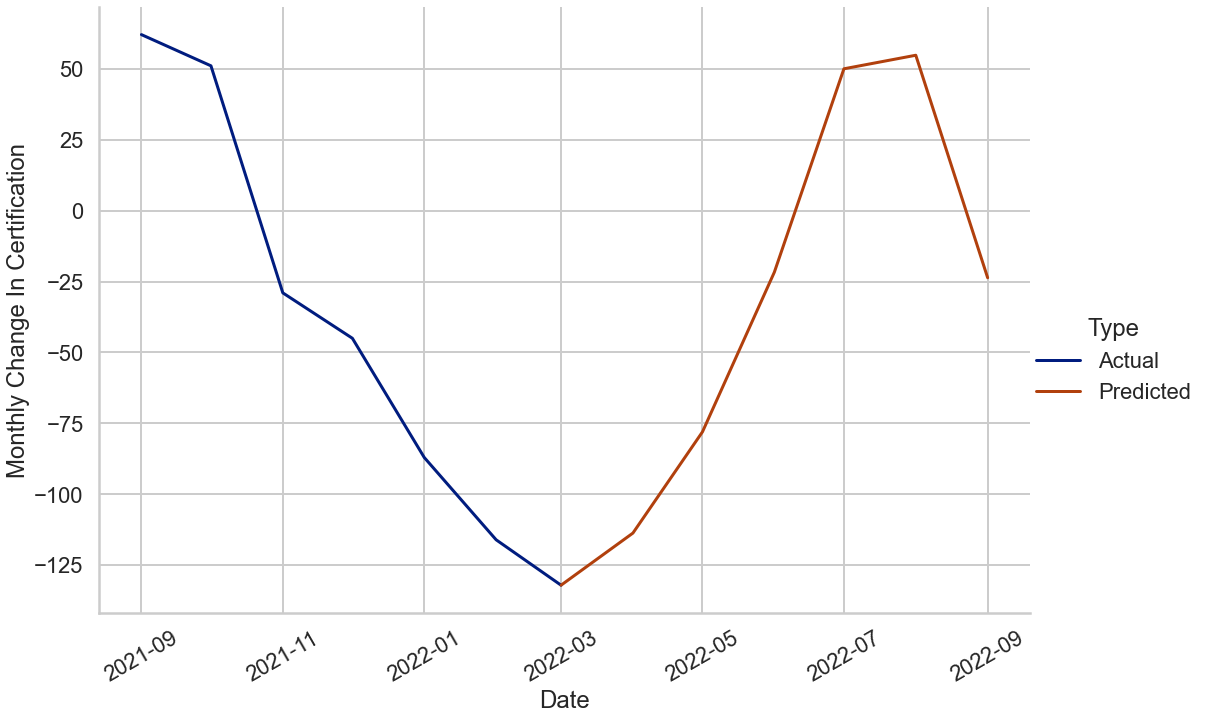

In [65]:
sns.set_style('whitegrid')
sns.set_palette('dark')
sns.set_context("poster")

#sns.lineplot(data=trend, x="Month", y="Trend", hue="Type")
sns.relplot(data=trend_pred_show, x='Month', y='Trend', kind='line', hue='Type',height=10, aspect=1.5)
#plt.title('Certification Changes Over Time')
plt.xlabel('Date')
plt.ylabel('Monthly Change In Certification')
plt.xticks(rotation=30)

In [66]:
# Calculate the total count of overall operations throughout the timeframe of the prediction.
start_count = trend_df.loc[trend_pred_df.Month.min(), "total_count"]

first=True
count_list = list()
month_list = list()
for index, row in trend_pred_df.iterrows():
    if first:
        current_count = start_count
        first=False
    else:
        current_count = current_count + row["Trend"]
    month_list.append(row["Month"])
    count_list.append(current_count)
count_df = pd.DataFrame(zip(month_list, count_list), columns=["Month", "total_count"])

trend_pred_count_df = trend_pred_df.merge(right=count_df,on="Month",how="inner")

In [67]:
# Duplicate the last record of known value in order to show a smooth continuation.
max_actual = trend_pred_count_df.loc[trend_pred_count_df["Type"]=="Actual","Month"].max()

line_continue = trend_pred_count_df.loc[trend_pred_count_df["Month"]==max_actual].copy()
line_continue["Type"] = "Predicted"

trend_pred_count_show = pd.concat([trend_pred_count_df,line_continue]).reset_index()

(array([18871., 18932., 18993., 19052., 19113., 19174., 19236.]),
 [Text(18871.0, 0, '2021-09'),
  Text(18932.0, 0, '2021-11'),
  Text(18993.0, 0, '2022-01'),
  Text(19052.0, 0, '2022-03'),
  Text(19113.0, 0, '2022-05'),
  Text(19174.0, 0, '2022-07'),
  Text(19236.0, 0, '2022-09')])

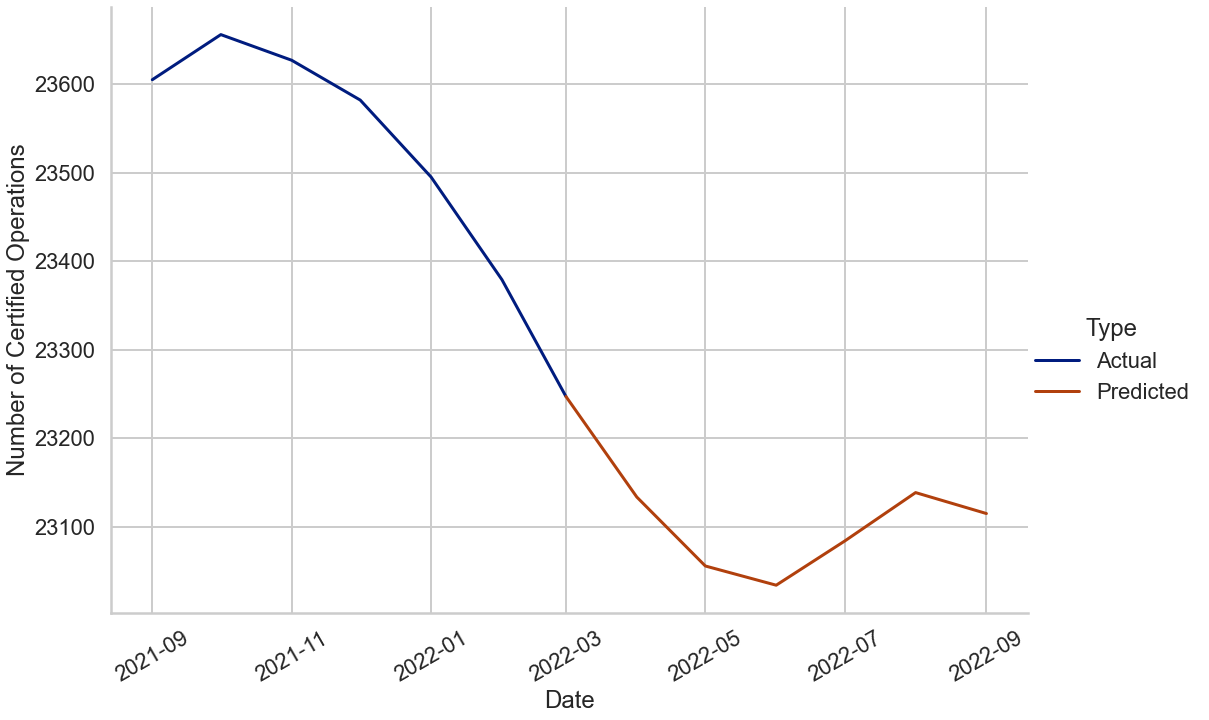

In [68]:
sns.set_style('whitegrid')
sns.set_palette('dark')
sns.set_context("poster")

#sns.lineplot(data=trend, x="Month", y="Trend", hue="Type")
sns.relplot(data=trend_pred_count_show, x='Month', y='total_count', kind='line', hue='Type',height=10, aspect=1.5)
#plt.title('Certification Changes Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Certified Operations')
plt.xticks(rotation=30)